In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import glob, os
import numpy as np
from scipy.stats import pointbiserialr, spearmanr

In [2]:
# Define the folder path containing your CSV files
folder_path = "Dataset"

# Find all CSV files in that folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Create a list to hold all DataFrames
dfs = []

# Loop through the files and read them
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)
    
# Merge all CSVs into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Display first few rows to confirm merge
display(merged_df.head())

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Deal with Null and Infinity Values

In [3]:
# Drop rows with null values
merged_df.dropna(inplace=True)

In [4]:
# Make a copy to avoid modifying the original DataFrame accidentally
df = merged_df.copy()

# Identify numeric columns only (skip non-numerical ones like label)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Check for infinite values (only in numeric columns)
inf_counts = np.isinf(df[numeric_cols]).sum()

# Display only columns that contain infinity
inf_columns = inf_counts[inf_counts > 0]

if not inf_columns.empty:
    print("Columns containing infinity values:")
    for col, count in inf_columns.items():
        print(f" - {col}: {count} infinite values")
else:
    print("No infinite values found in numeric columns.")

# Drop rows that contain any infinity values (across all numeric columns)
rows_before = len(df)
df = df[~np.isinf(df[numeric_cols]).any(axis=1)].copy()
rows_after = len(df)

print(f"Rows with infinity values removed: {rows_before - rows_after}")
print(f"Remaining rows: {rows_after}")

# Replace the original DataFrame if desired
merged_df = df


Columns containing infinity values:
 - Flow Bytes/s: 669 infinite values
 -  Flow Packets/s: 669 infinite values
Rows with infinity values removed: 669
Remaining rows: 991113


In [5]:
selected_features = [
    ' Destination Port', ' Fwd Packet Length Max',
    ' Fwd Packet Length Mean', 'Bwd Packet Length Max',
    ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
    ' Bwd Packet Length Std', ' Fwd IAT Std', 'Bwd IAT Total',
    ' Bwd IAT Max', ' Min Packet Length', ' Max Packet Length',
    ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
    ' PSH Flag Count', ' URG Flag Count', ' Average Packet Size',
    ' Avg Fwd Segment Size', ' Avg Bwd Segment Size'
]

In [6]:
target_col = ' Label'

# Ensure target is numeric (0=benign, 1=malicious)
if merged_df[target_col].dtype == 'object':
    merged_df[target_col] = merged_df[target_col].astype('category').cat.codes


In [7]:
# Compute correlations
corrs = {}
for feat in selected_features:
    # Use point-biserial correlation (for continuous vs binary target)
    r, p = pointbiserialr(df[feat], df[target_col])
    corrs[feat] = (r, p)

corr_df = pd.DataFrame.from_dict(corrs, orient='index', columns=['Correlation', 'p-value'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

display(corr_df)

,Correlation,p-value
PSH Flag Count,0.494591,0.000000
Bwd Packet Length Std,0.155552,0.000000
Packet Length Variance,0.142368,0.000000
Bwd Packet Length Max,0.133759,0.000000
Bwd Packet Length Mean,0.120759,0.000000
Avg Bwd Segment Size,0.120759,0.000000
Packet Length Std,0.105306,0.000000
Max Packet Length,0.089205,0.000000
Packet Length Mean,0.063800,0.000000
Average Packet Size,0.063116,0.000000


/tmp/ipykernel_200394/1287390819.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df.reset_index(), x='Correlation', y='index', palette='coolwarm')


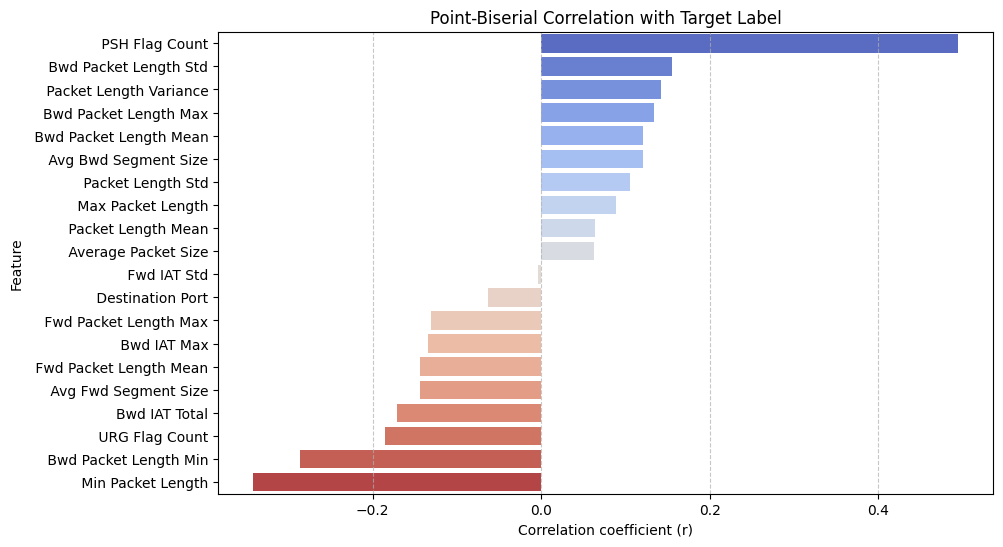

In [8]:
# Visualize correlation strength
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df.reset_index(), x='Correlation', y='index', palette='coolwarm')
plt.title("Point-Biserial Correlation with Target Label")
plt.xlabel("Correlation coefficient (r)")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

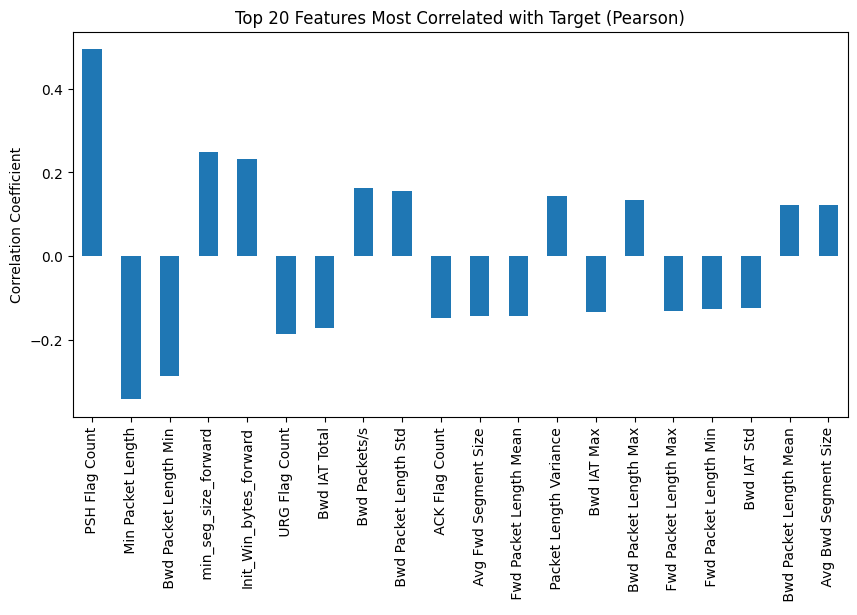

In [ ]:
# (Optional) Feature vs Target Boxplots
# Visualize distributions of top correlated features
top_feats = corr_df.head(5).index.tolist()
plt.figure(figsize=(14, 8))
for i, feat in enumerate(top_feats, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=target_col, y=feat, data=df, palette='Set2')
    plt.title(f"{feat} vs Target")
plt.tight_layout()
plt.show()